## Wildfire Data Analysis
This Notebook describes processes for the data acquistion, preparation and analysis for the the wildfire data from USGS. It also uses data from the EPA API which returns air quality for specific geographic locations.


## License
The code snippets below which define the reader, functions to calculate distance and change projections was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/)


In [31]:
#
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#    
from Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson

import pandas as pd
#
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
SAMPLE_DATA_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
#
#    Open a file, load it with the geojson loader
#
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_C

## Read in the Wildfire Data


The code snippet below uses the wfreader object and its methods that are defined in the Reader module defined and developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/) and more information about this can be found at: https://drive.google.com/file/d/1TwCkvdaw0MxJzW7NSDg6XxYQ0dvaS44I/view?usp=sharing

In [4]:
#
#    This sample code will load the whole sample file, or a small amount of the complete dataset.
#

feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features
Variable 'feature_list' contains 135061 features


## Helper Functions

1. convert_ring_to_epsg4326 - The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326. The function returns a list of coordinates in EPSG:4326. This is required for the geodetic computation step
2. shortest_distance_from_place_to_fire_perimeter - The function takes two parameters:
    * A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326. 
    * Ring_data - a list of decimal degree coordinates for the fire boundary 
    The function returns a list containing the shortest distance to the perimeter and the point where that is
3. average_distance_from_place_to_fire_perimeter - The function takes two parameters:
    * A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
    * Ring_data - a list of decimal degree coordinates for the fire boundary
    The function returns the average miles from boundary to the place
    
For this particular analysis, I decided to use the average_distance_from_place_to_fire_perimeter as the distance computation method, however I also believe that the shortest_distance_from_place_to_fire_perimeter is also an accurate estimate of distance from a wildfire.


In [5]:
# define helper functions for the tasks
# 1. 
#
#    Transform feature geometry data
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

# 2.
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


# 3.
#    
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

In [6]:
# my city for smoke analysis - Lewiston, Idaho
CITY_LOCATIONS = {
    'lw' : {
        'city': 'Lewiston',
        'latlon': [46.4004, -117.0012]
    }
}

In [20]:
res = [] # a list to hold the response jsons from the wildfire data
place = CITY_LOCATIONS["lw"]
for wf_feature in tqdm(feature_list):
    # a try and except to catch any missing attributes
    try:
        wf_year = wf_feature['attributes']['Fire_Year']
        wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
        wf_size = wf_feature['attributes']['GIS_Acres']
        wf_type = wf_feature['attributes']['Assigned_Fire_Type']
        ring_data = wf_feature['geometry']['rings'][0]
    except:
        print("Attribute value missing")
    if 'rings' in wf_feature['geometry']:
        distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
        # defining the constraints for the scope of this project
        if distance <= 1250 and wf_year >= 1963:
            wf_feature['attributes']['distance'] = distance
            res.append(wf_feature['attributes'])

 81%|████████████████████████████▍      | 109611/135061 [56:35<12:53, 32.90it/s]

Attribute value missing


 82%|████████████████████████████▌      | 110228/135061 [56:54<12:01, 34.43it/s]

Attribute value missing


 82%|████████████████████████████▋      | 110645/135061 [57:08<12:24, 32.81it/s]

Attribute value missing


 83%|████████████████████████████▉      | 111438/135061 [57:32<11:47, 33.41it/s]

Attribute value missing


 83%|████████████████████████████▉      | 111783/135061 [57:43<11:57, 32.44it/s]

Attribute value missing


 83%|████████████████████████████▉      | 111904/135061 [57:47<11:37, 33.22it/s]

Attribute value missing


 83%|█████████████████████████████▏     | 112418/135061 [58:03<10:19, 36.57it/s]

Attribute value missing
Attribute value missing


 84%|█████████████████████████████▍     | 113415/135061 [58:35<10:40, 33.78it/s]

Attribute value missing


 84%|█████████████████████████████▍     | 113671/135061 [58:43<10:45, 33.16it/s]

Attribute value missing


 84%|█████████████████████████████▍     | 113744/135061 [58:45<10:44, 33.09it/s]

Attribute value missing


 84%|█████████████████████████████▍     | 113773/135061 [58:46<10:31, 33.69it/s]

Attribute value missing


 84%|█████████████████████████████▍     | 113810/135061 [58:47<10:39, 33.22it/s]

Attribute value missing


 85%|█████████████████████████████▌     | 114315/135061 [59:03<10:17, 33.59it/s]

Attribute value missing


 85%|█████████████████████████████▋     | 114328/135061 [59:03<10:00, 34.55it/s]

Attribute value missing


 86%|█████████████████████████████▉     | 115636/135061 [59:45<09:56, 32.58it/s]

Attribute value missing


 86%|██████████████████████████████     | 115981/135061 [59:56<09:33, 33.30it/s]

Attribute value missing


 86%|████████████████████████████▍    | 116242/135061 [1:00:04<09:27, 33.15it/s]

Attribute value missing


 87%|████████████████████████████▌    | 117091/135061 [1:00:30<08:56, 33.49it/s]

Attribute value missing


 89%|█████████████████████████████▏   | 119588/135061 [1:01:49<07:41, 33.53it/s]

Attribute value missing


 89%|█████████████████████████████▏   | 119621/135061 [1:01:50<07:27, 34.54it/s]

Attribute value missing


 89%|█████████████████████████████▎   | 119758/135061 [1:01:54<07:38, 33.37it/s]

Attribute value missing


 89%|█████████████████████████████▎   | 119987/135061 [1:02:01<07:23, 33.96it/s]

Attribute value missing


 89%|█████████████████████████████▎   | 120216/135061 [1:02:08<07:13, 34.26it/s]

Attribute value missing


 89%|█████████████████████████████▍   | 120437/135061 [1:02:15<07:05, 34.34it/s]

Attribute value missing


 89%|█████████████████████████████▍   | 120682/135061 [1:02:22<07:08, 33.53it/s]

Attribute value missing


 89%|█████████████████████████████▌   | 120747/135061 [1:02:24<07:02, 33.88it/s]

Attribute value missing


 90%|█████████████████████████████▌   | 121016/135061 [1:02:33<06:58, 33.55it/s]

Attribute value missing


 91%|█████████████████████████████▊   | 122269/135061 [1:03:12<06:32, 32.63it/s]

Attribute value missing


 91%|█████████████████████████████▉   | 122538/135061 [1:03:20<06:18, 33.05it/s]

Attribute value missing


 92%|██████████████████████████████▏  | 123767/135061 [1:03:59<05:38, 33.36it/s]

Attribute value missing


 92%|██████████████████████████████▍  | 124540/135061 [1:04:23<05:13, 33.59it/s]

Attribute value missing


 93%|██████████████████████████████▌  | 125053/135061 [1:04:39<04:54, 34.02it/s]

Attribute value missing


 93%|██████████████████████████████▋  | 125751/135061 [1:05:02<04:41, 33.07it/s]

Attribute value missing


 94%|███████████████████████████████▏ | 127499/135061 [1:05:57<03:44, 33.63it/s]

Attribute value missing


100%|█████████████████████████████████| 135061/135061 [1:09:51<00:00, 32.22it/s]


In [21]:
# File path to save the JSON data locally
file_path = "data_fires_lewiston.json"

# Open the file in write mode and save the data as JSON
with open(file_path, 'w') as json_file:
    json.dump(res, json_file)

In [22]:
# checking the length of the list of dictionary attributes
len(res)

78611

In [24]:
# displaying one of the values in res
res[1]

{'OBJECTID': 14300,
 'USGS_Assigned_ID': 14300,
 'Assigned_Fire_Type': 'Wildfire',
 'Fire_Year': 1963,
 'Fire_Polygon_Tier': 1,
 'Fire_Attribute_Tiers': '1 (1), 3 (3)',
 'GIS_Acres': 25757.09020335899,
 'GIS_Hectares': 10423.524591179945,
 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Northern_Rockies_1889_2003 (1), Comb_National_WFDSS_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Final_Fire_Perimeter (1)',
 'Listed_Fire_Types': 'Wildfire (2), Likely Wildfire (2)',
 'Listed_Fire_Names': 'McChord Butte (2), No Fire Name Provided (1), Mcchord Butte (1)',
 'Listed_Fire_Codes': 'No code provided (4)',
 'Listed_Fire_IDs': '',
 'Listed_Fire_IRWIN_IDs': '',
 'Listed_Fire_Dates': 'Listed Wildfire Discovery Date(s): 1963-07-28 (1) | Listed Other Fire Date(s): 2019-09-13 - NIFC DATE_CUR field (1), 2019-09-13 - REVDATE field (1)',
 'Listed_Fire_Causes': '',
 'Listed_Fire_Cause_Class': 'Undetermined (4)',
 'Listed_Rx_Reported_Acres':

## Results from the AQI API

In [189]:
# read in the file that contains AQI data for areas in and around Lewiston Idaho.
# this data was obtained from the aqi_data_acquistion.ipynb 
with open('aqi_lewiston.json', 'r') as file:
    aqi_year = json.load(file)
aqi_year

{'1986': 34.51851851851852,
 '1987': 36.03448275862069,
 '1988': 36.22222222222222,
 '1989': 33.60683760683761,
 '1990': 29.28421052631579,
 '1991': 38.77777777777778,
 '1992': 27.69747899159664,
 '1993': 33.68595041322314,
 '1994': 28.33613445378151,
 '1995': 25.552845528455286,
 '1996': 23.96694214876033,
 '1997': 25.72641509433962,
 '1998': 24.47747747747748,
 '1999': 34.77477477477478,
 '2000': 38.44748858447488,
 '2001': 34.02832618025751,
 '2002': 31.381132075471697,
 '2003': 21.96712328767123,
 '2004': 22.13565536205316,
 '2005': 19.678341013824884,
 '2006': 21.56583969465649,
 '2007': 21.169617893755824,
 '2008': 21.0757299270073,
 '2009': 20.994366197183098,
 '2010': 18.10810810810811,
 '2011': 18.32264150943396,
 '2012': 20.44177093358999,
 '2013': 22.351224105461394,
 '2014': 19.526621490803485,
 '2015': 22.881278538812786,
 '2016': 16.399803536345775,
 '2017': 22.630940343781596,
 '2018': 21.763012181616833,
 '2019': 17.247895229186156,
 '2020': 17.84540636042403,
 '2021': 

## Creating a Smoke Estimate 

After going through the attributes of the fires recorded in the [metadata of the USGS dataset](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0%2F63%2F53%2Fd063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true), I believe that an appropriate smoke estimate can be created
from 3 attributes:
1. GIS_Hectares
2. distance
3. Assigned_Fire_Type

**GIS_Hectares** : The GIS calculated hectares of the fire polygon calculated by using the Calculate Geometry tool in ArcGIS Pro.

**distance** : The average miles from the fire boundary to the Lewiston, Idaho.

**Assigned_Fire_Type** : An attribute that can take 5 values

1. Likely Wildfire : The fire was likely a wildfire but there is no way to confirm this.
2. Wildfire : The fire is a confirmed wildfire based on the available attributes.
3. Prescribed Wildfire : The fire is a confirmed prescribed fire based on the available attributes.
4. Unknown - Likely Wildfire : This polygon came from MTBS and was labeled "Unknown". However, research done by Karen Short indicates that the fire is likely a wildfire.
5. Unknown - Likely Prescribed Wildfire : This polygon came from MTBS and was labeled "Unknown". However, research done by Karen Short indicates that the fire is likely a prescribed fire.

The values where the attribute has the word "likely" also leaves room for a scenario where this fire may not have occurred at all. However, when it takes values like "Prescribed Wildfire" and "Wildfire", there is some assurance of 
this fire having occurred. 

Based on this I believe that the values that this attribute takes can be weighted based on assurance of a fire
taking place
1. Likely Wildfire : 15 (The assurance of the wildfire occurring is not given)
2. Wildfire : 20 (assured wildfire)
3. Prescribed Wildfire : 12.5 (assured prescribed wildfire which burns fewer acres than compared to wildfires)
4. Unknown - Likely Wildfire : 20 (research indicates that this is an assured wildfire)
5. Unknown - Likely Prescribed Wildfire : 12.5 (research indicates that this is an assured prescribed wildfire)
6. Other : 1


**smoke_estimate = (GIS_Hectares/distance) * Assigned_Fire_Type_Code**  

**note: the GIS_Hectares is converted to Miles^2 before dividing it by the distance calculated in Miles**

In [196]:
res_smoke = res
# the assigned_fire_type is mapped to numbers that signify the weight that it would give in the smoke estimate
assigned_fire_type_code = {
    'Likely Wildfire': 15,
    'Wildfire': 20,
    'Prescribed Wildfire': 12.5,
    'Unknown - Likely Wildfire': 20,
    'Unknown - Likely Prescribed Wildfire': 12.5
}
for wf_feature in tqdm(res_smoke):
    try:
        fire_type = wf_feature['Assigned_Fire_Type']
        fire_area = wf_feature['GIS_Hectares']/258.998811 #to convert the area to miles^2 
        fire_distance = wf_feature['distance']
    except:
        print("There is a missing attribute")
    if 'Assigned_Fire_Type' in wf_feature:
        if fire_type in assigned_fire_type_code:
            smoke_estimate = (fire_area/fire_distance) * assigned_fire_type_code[fire_type]
        else:
            smoke_estimate = fire_area/fire_distance
        wf_feature['smoke_estimate'] = smoke_estimate

100%|████████████████████████████████████| 78611/78611 [00:00<00:00, 84685.76it/s]


In [197]:
# viewing the first element of the list
res_smoke[0]

{'OBJECTID': 14299,
 'USGS_Assigned_ID': 14299,
 'Assigned_Fire_Type': 'Wildfire',
 'Fire_Year': 1963,
 'Fire_Polygon_Tier': 1,
 'Fire_Attribute_Tiers': '1 (1), 3 (3)',
 'GIS_Acres': 40992.45827111476,
 'GIS_Hectares': 16589.05930244248,
 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_SubState_MNSRBOPNCA_Wildfires_Historic (1), Comb_SubState_BLM_Idaho_NOC_FPER_Historica_Fire_Polygons (1), Comb_National_BLM_Fire_Perimeters_LADP (1)',
 'Listed_Fire_Types': 'Wildfire (1), Likely Wildfire (3)',
 'Listed_Fire_Names': 'RATTLESNAKE (4)',
 'Listed_Fire_Codes': 'No code provided (4)',
 'Listed_Fire_IDs': '1963-NA-000000 (2)',
 'Listed_Fire_IRWIN_IDs': '',
 'Listed_Fire_Dates': 'Listed Wildfire Discovery Date(s): 1963-08-06 (3) | Listed Wildfire Controlled Date(s): 1963-12-31 (3)',
 'Listed_Fire_Causes': 'Unknown (3)',
 'Listed_Fire_Cause_Class': 'Undetermined (4)',
 'Listed_Rx_Reported_Acres': None,
 'Listed_Map_Digitize_Methods': 'Digitized-Topo (4)',
 'Lis

In [211]:
# extract only the features that are required for analysis and save it in a list: res_mini
res_mini = []
for wf_feature in tqdm(res_smoke):
    mini_feature = {}
    mini_feature['USGS_Assigned_ID'] = wf_feature['USGS_Assigned_ID']
    mini_feature['Assigned_Fire_Type'] = wf_feature['Assigned_Fire_Type']
    mini_feature['Fire_Year'] = wf_feature['Fire_Year']
    mini_feature['GIS_Hectares'] = wf_feature['GIS_Hectares']
    mini_feature['Listed_Fire_Names'] = wf_feature['Listed_Fire_Names']
    mini_feature['distance'] = wf_feature['distance']
    mini_feature['smoke_estimate'] = wf_feature['smoke_estimate']
    res_mini.append(mini_feature)
    
# convert res_mini to a dataframe
df_mini = pd.DataFrame(res_mini)
df_mini.head()

100%|███████████████████████████████████| 78611/78611 [00:00<00:00, 265858.01it/s]


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Hectares,Listed_Fire_Names,distance,smoke_estimate
0,14299,Wildfire,1963,16589.059302,RATTLESNAKE (4),147.463431,8.686997
1,14300,Wildfire,1963,10423.524591,"McChord Butte (2), No Fire Name Provided (1), ...",132.134128,6.091606
2,14301,Wildfire,1963,18424.208617,"WILLOW CREEK (16), EAST CRANE CREEK (4), Crane...",141.476152,10.056291
3,14302,Wildfire,1963,4206.711433,"SOUTH CANYON CREEK (4), No Fire Name Provided (1)",227.902521,1.425364
4,14303,Wildfire,1963,4040.221900,WEBB CREEK (4),159.883818,1.951340


In [212]:
# viewing the distribution of values for the smoke_estimate attribute
df_mini['smoke_estimate'].describe()

count    7.861100e+04
mean     1.683450e-01
std      1.642836e+00
min      3.084128e-10
25%      2.488391e-04
50%      2.103956e-03
75%      2.069164e-02
max      1.435315e+02
Name: smoke_estimate, dtype: float64

In [213]:
# create a copy of this dataframe
df_mini_copy = df_mini

In [214]:
# filtering out values of the smoke_estimate attribute that are lesser than two because this would mean
# that the wildfire occurred at a large distance away from the city or that the area of land that the fire
# burnt was small or both. This would mean that the fire would not affect the overall AQI of the my city
df_mini = df_mini[df_mini['smoke_estimate'] > 2]

In [215]:
# Performing a groupby on year and aggregation on mean to get the average smoke_estimate for each year
result = df_mini.groupby("Fire_Year")["smoke_estimate"].mean()
result.head()

Fire_Year
1963     8.278298
1964     2.660020
1965    10.897260
1966     3.994472
1967     7.773989
Name: smoke_estimate, dtype: float64

In [317]:
# convert the result to a dataframe
result_df = result.reset_index()
result_df.head()

,Fire_Year,smoke_estimate
0,1963,8.278298
1,1964,2.660020
2,1965,10.897260
3,1966,3.994472
4,1967,7.773989


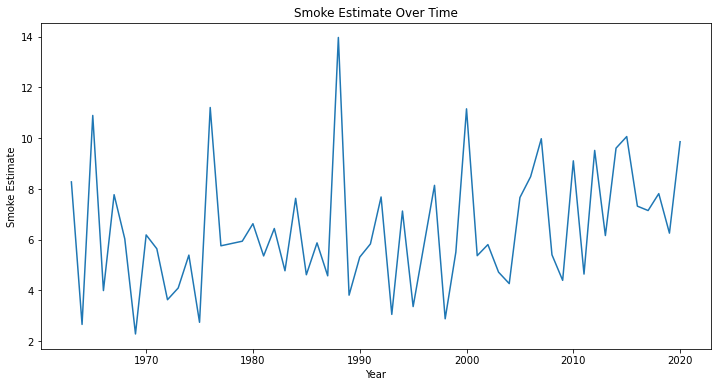

In [220]:
# Visualize the smoke estimate over time
result_df['Fire_Year'] = pd.to_datetime(result_df['Fire_Year'], format='%Y')
result_df.set_index('Fire_Year', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(result_df['smoke_estimate'])
plt.title('Smoke Estimate Over Time')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()


# Time Series Forecasting

For this project, the Autoregressor model is chosen to forecast future values. An AR model takes into account the relationship between the current value and past values, which is crucial for modeling and forecasting time series data accurately. By including lagged values, the model can capture the influence of previous observations on future observations. The lag_order attribute helps define the number of past data points to look at before making a prediction for the future and this is helpful in this particular case since there is some uncertainty about the results in the earlier years. Additionally, AR models are relatively simple and easy to interpret. They rely on a small number of parameters.

In [291]:
# import the AutoReg model from statsmodel
from statsmodels.tsa.ar_model import AutoReg
# Fit the AutoReg model
lag_order = 8  # number of historical data to look at to make predictions in the future
model3 = AutoReg(data['smoke_estimate'], lags=lag_order)
model_fit3 = model3.fit()

# Forecast future values
forecast3 = model_fit3.predict(start=0, end=len(data) + 25)  # Steps indicate the number of future points to predict for

/Users/mithalishashidhar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mithalishashidhar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mithalishashidhar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [293]:
# viewing the forecast
list(forecast3)

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 7.285568609510407,
 5.65951232054586,
 7.1270504166006585,
 6.097530522854212,
 5.604780756446536,
 6.655364517225046,
 4.586141443961763,
 5.775089174745524,
 6.159228544627376,
 6.249502881773239,
 6.328262842732881,
 7.341310439116973,
 6.289725628781761,
 6.383804102531846,
 6.714715574393947,
 6.284704167632556,
 6.702544148014889,
 4.6781120235502245,
 7.291243082456165,
 6.5747971277926265,
 6.933978636131904,
 6.2716721235346835,
 8.237274423797249,
 5.435640146654556,
 7.193925592876103,
 6.158313198350312,
 5.898173752721435,
 6.301909127001536,
 6.61276837655729,
 4.707263927254309,
 6.734701342858147,
 6.753695172221829,
 6.359521390445621,
 7.174669641870015,
 6.641748090128547,
 5.500102109569181,
 5.9574554436960945,
 6.643212371482519,
 7.086299692713892,
 6.6290239570035965,
 7.325985099875336,
 6.551849639377901,
 6.51393065466158,
 6.191362952648081,
 6.680759609147382,
 6.62559104945687,
 7.83919036357046,
 6.86279868

In [297]:
# removing the first 8 nan values in the forecasted data which is a result of the lag set to 8
import math
forecast3 = [x for x in forecast3 if not math.isnan(x)]

In [298]:
# Creating a dictionary to hold the year and value predicted for that year to visualize the results
predicted_values = {}
i=0
for year in range(1971, 2024):
    predicted_values[year] = forecast3[i]
    i += 1
predicted_values

{1971: 7.285568609510407,
 1972: 5.65951232054586,
 1973: 7.1270504166006585,
 1974: 6.097530522854212,
 1975: 5.604780756446536,
 1976: 6.655364517225046,
 1977: 4.586141443961763,
 1978: 5.775089174745524,
 1979: 6.159228544627376,
 1980: 6.249502881773239,
 1981: 6.328262842732881,
 1982: 7.341310439116973,
 1983: 6.289725628781761,
 1984: 6.383804102531846,
 1985: 6.714715574393947,
 1986: 6.284704167632556,
 1987: 6.702544148014889,
 1988: 4.6781120235502245,
 1989: 7.291243082456165,
 1990: 6.5747971277926265,
 1991: 6.933978636131904,
 1992: 6.2716721235346835,
 1993: 8.237274423797249,
 1994: 5.435640146654556,
 1995: 7.193925592876103,
 1996: 6.158313198350312,
 1997: 5.898173752721435,
 1998: 6.301909127001536,
 1999: 6.61276837655729,
 2000: 4.707263927254309,
 2001: 6.734701342858147,
 2002: 6.753695172221829,
 2003: 6.359521390445621,
 2004: 7.174669641870015,
 2005: 6.641748090128547,
 2006: 5.500102109569181,
 2007: 5.9574554436960945,
 2008: 6.643212371482519,
 2009: 7.

In [318]:
# save the file locally
with open('predicted_values.json', 'w') as file:
    json.dump(predicted_values, file)

In [311]:
# converting the dictionary above with predicted values to a dataframe
predicted_df = pd.DataFrame(list(predicted_values.items()), columns=['year', 'smoke_estimate'])
predicted_df.head()

,year,smoke_estimate
0,1971,7.285569
1,1972,5.659512
2,1973,7.127050
3,1974,6.097531
4,1975,5.604781


In [304]:
# This uses one of the earlier defined notebooks with smoke estimates as calculated from the wildfire data
result_df_new = result_df.reset_index()
result_df_new['Fire_Year'] = pd.to_datetime(result_df_new['Fire_Year']).dt.year
result_df_new.head()

,Fire_Year,smoke_estimate
0,1963,8.278298
1,1964,2.660020
2,1965,10.897260
3,1966,3.994472
4,1967,7.773989


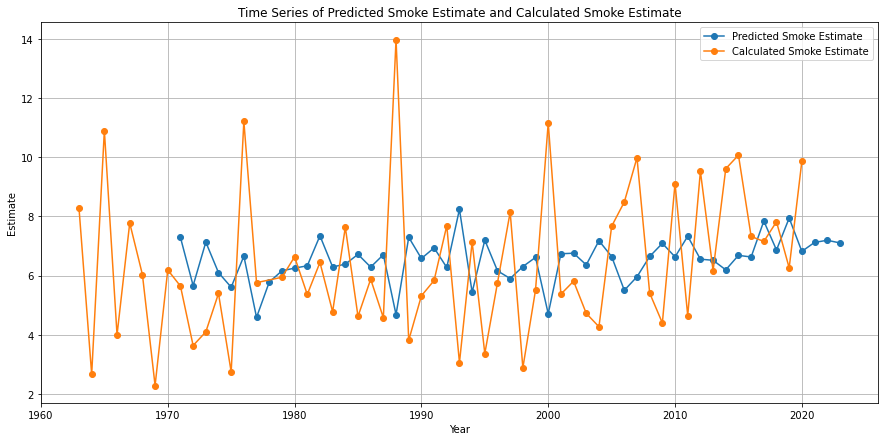

In [314]:
# This is a graph representing the predicted v/s actual smoke estimates 
# Create the time series graph
plt.figure(figsize=(15, 7))
plt.plot(predicted_df['year'], predicted_df['smoke_estimate'], label='Predicted Smoke Estimate', marker='o', linestyle='-')
plt.plot(result_df_new['Fire_Year'], result_df_new['smoke_estimate'], label='Calculated Smoke Estimate', marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.title('Time Series of Predicted Smoke Estimate and Calculated Smoke Estimate')
plt.legend()

# Show the graph
plt.grid(True)
plt.show()

# Step 2: Visualize aspects of your analysis

## Visualization 1: 
Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.



In [233]:
# create a smaller dataframe with an ID field and the field under study - distance
dist_df = df_mini_copy[['USGS_Assigned_ID', 'distance']]
dist_df.head()

,USGS_Assigned_ID,distance
0,14299,147.463431
1,14300,132.134128
2,14301,141.476152
3,14302,227.902521
4,14303,159.883818


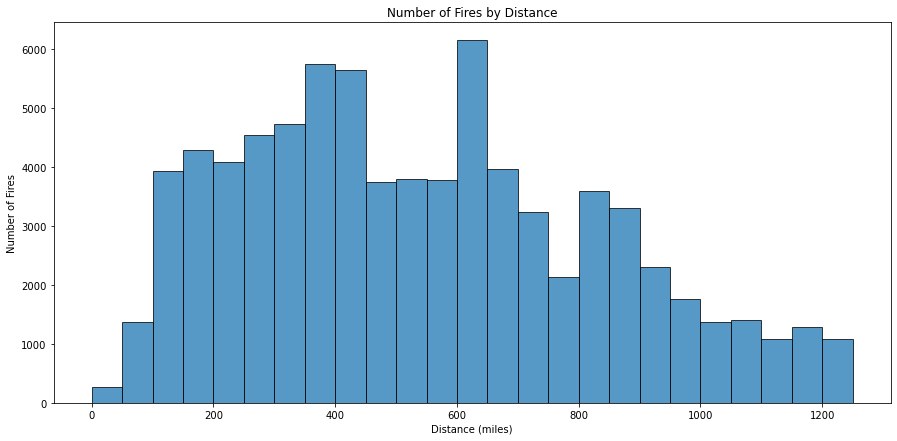

In [241]:
# Define the maximum specified distance
max_distance = 1250  

# Create bins for the histogram
bin_width = 50
num_bins = int(max_distance / bin_width)
bins = [i * bin_width for i in range(num_bins + 1)]

plt.figure(figsize=(15,7))
# Use the 'distance' column to create the histogram
plt.hist(dist_df['distance'], bins=bins, edgecolor='k', alpha=0.75)

# Set labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance')

# Show the histogram
plt.show()

## Visualization 2: 
Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.


In [315]:
# create a smaller dataframe with an ID field and the fields under study - GIS_Hectares and Fire_Year
df_area = df_mini_copy[['USGS_Assigned_ID', 'GIS_Hectares', 'Fire_Year']]
# convert hectares to acres
df_area['GIS_Acres'] = df_area['GIS_Hectares'] * 2.4710538147

/var/folders/wf/j2bykxxs0sv87m6vct6sttxc0000gn/T/ipykernel_57682/3433708826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area['GIS_Acres'] = df_area['GIS_Hectares'] * 2.4710538147


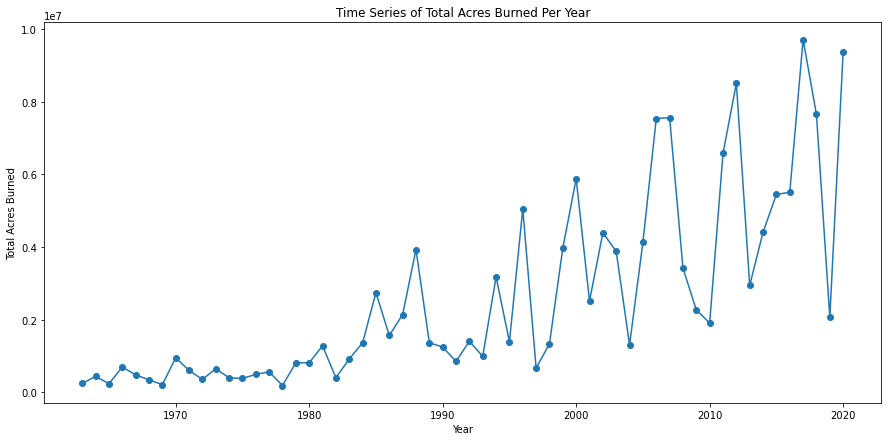

In [316]:
# Group and sum the total acres burned per year
total_acres_burned_per_year = df_area.groupby('Fire_Year')['GIS_Acres'].sum()
plt.figure(figsize=(15,7))
# Create a time series graph
plt.plot(total_acres_burned_per_year.index, total_acres_burned_per_year.values, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Time Series of Total Acres Burned Per Year')

# Show the graph
plt.show()

## Visualization 3: 
Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.


In [262]:
# use the results dataframe from above with the year and smoke estimate as calculated using the defined formula
result_df_new = result_df.reset_index()
result_df_new['year'] = pd.to_datetime(result_df_new['Fire_Year']).dt.year
result_df_new.head()

,Fire_Year,smoke_estimate,year
0,1963-01-01,8.278298,1963
1,1964-01-01,2.660020,1964
2,1965-01-01,10.897260,1965
3,1966-01-01,3.994472,1966
4,1967-01-01,7.773989,1967


In [266]:
# convert the dictionary of aqi and year to a dataframe of the same for visualization
aqi_year_df = pd.DataFrame(list(aqi_year.items()), columns=['year', 'AQI'])
aqi_year_df['year'] = pd.to_datetime(aqi_year_df['year']).dt.year
aqi_year_df.head()

,year,AQI
0,1986,34.518519
1,1987,36.034483
2,1988,36.222222
3,1989,33.606838
4,1990,29.284211


In [276]:
# join the above two dataframes based on year
merged_df = pd.merge(result_df_new, aqi_year_df, on='year', how='inner')
merged_df.head()

,Fire_Year,smoke_estimate,year,AQI
0,1986-01-01,5.874813,1986,34.518519
1,1987-01-01,4.576164,1987,36.034483
2,1988-01-01,13.971327,1988,36.222222
3,1989-01-01,3.813257,1989,33.606838
4,1990-01-01,5.313378,1990,29.284211


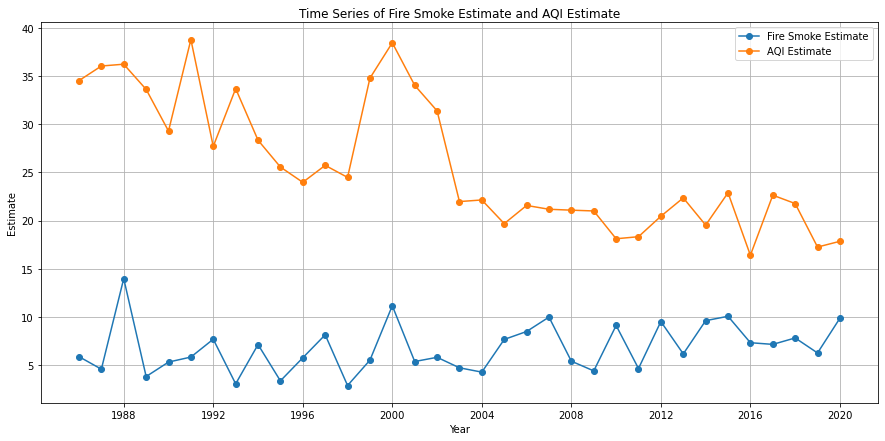

In [282]:
merged_df['year'] = pd.to_datetime(merged_df['Fire_Year'])

# Create the time series graph
plt.figure(figsize=(15, 7))
plt.plot(merged_df['year'], merged_df['smoke_estimate'], label='Fire Smoke Estimate', marker='o', linestyle='-')
plt.plot(merged_df['year'], merged_df['AQI'], label='AQI Estimate', marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.title('Time Series of Fire Smoke Estimate and AQI Estimate')
plt.legend()

# Show the graph
plt.grid(True)
plt.show()